In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns

## Read in merged weather / taxi data

In [2]:
chunklist = []
for chunk in pd.read_csv('data_merged.csv', chunksize = 100000):
    chunklist.append(chunk)

In [3]:
df = pd.concat(chunklist)

In [4]:
df.head()

,pickup,dropoff,trip_distance,trip_time,speed,tempm,precipm,precip_type
0,2016-02-05 00:00:00,2016-02-05 00:08:02,1.5,0 days 00:08:02.000000000,11.203320,6.7,0.0,clear
1,2016-02-05 00:00:01,2016-02-05 00:14:36,3.0,0 days 00:14:35.000000000,12.342857,6.7,0.0,clear
2,2016-02-05 00:00:02,2016-02-05 00:21:48,4.0,0 days 00:21:46.000000000,11.026034,6.7,0.0,clear
3,2016-02-05 00:00:02,2016-02-05 00:02:20,0.9,0 days 00:02:18.000000000,23.478261,6.7,0.0,clear
4,2016-02-05 00:00:03,2016-02-05 00:05:17,0.6,0 days 00:05:14.000000000,6.878981,6.7,0.0,clear


In [5]:
df['pickup'] = pd.to_datetime(df['pickup'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684583 entries, 0 to 1684582
Data columns (total 8 columns):
pickup           1684583 non-null datetime64[ns]
dropoff          1684583 non-null object
trip_distance    1684583 non-null float64
trip_time        1684583 non-null object
speed            1684583 non-null float64
tempm            1684583 non-null float64
precipm          1684583 non-null float64
precip_type      1684583 non-null object
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 102.8+ MB


## Explore the taxi/weather data by precip_type

In [7]:
df_grouped = df.groupby('precip_type')

In [8]:
rain = df_grouped.get_group('rain')
snow = df_grouped.get_group('snow')
clear = df_grouped.get_group('clear')

## Scatter plot of trip distances vs speeds with the precipitation
### Using the color map, we can see that the darker dots (higher precipitation) are more concentrated at the lower speeds

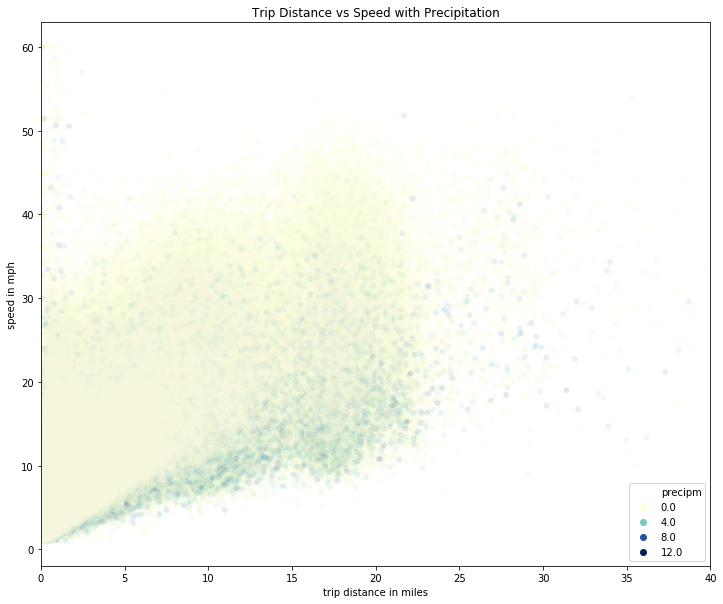

In [9]:
plt.figure(figsize = (12,10))
plt.xlim(0,40)
sns.scatterplot('trip_distance', 'speed', data = df, hue = 'precipm', hue_norm = (0,max(df.precipm)), alpha= 0.1, 
                palette = 'YlGnBu')
plt.title('Trip Distance vs Speed with Precipitation')
plt.xlabel('trip distance in miles')
plt.ylabel('speed in mph')
plt.show()

## Scatterplot of speed vs distance with the temperature
### Unsure if there is a clear pattern here

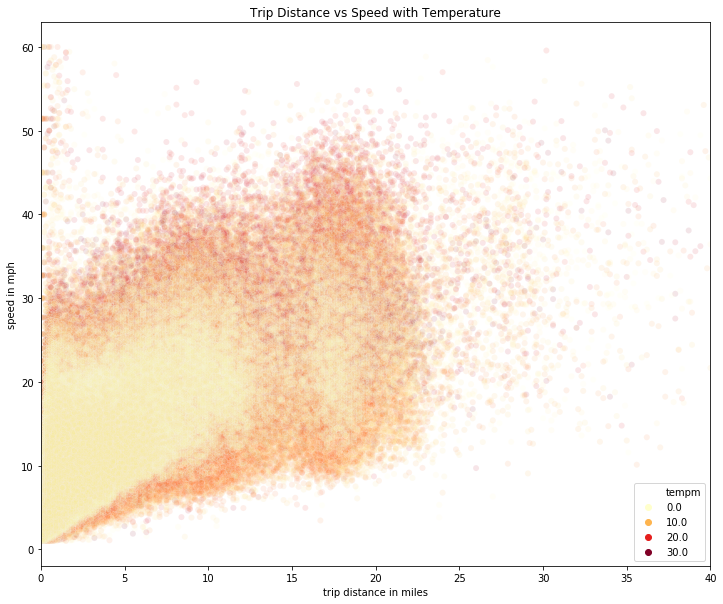

In [10]:
plt.figure(figsize = (12,10))
plt.xlim(0,40)
sns.scatterplot('trip_distance', 'speed', data = df, hue = 'tempm', hue_norm = (0,max(df.tempm)), alpha= 0.1, 
                palette = 'YlOrRd')
plt.title('Trip Distance vs Speed with Temperature')
plt.xlabel('trip distance in miles')
plt.ylabel('speed in mph')
plt.show()

## Distribution of speeds for days of rain, snow and clear days

In [11]:
def data_plots(x,y):
    data_rain = rain[(rain['trip_distance'] >= x) & (rain['trip_distance'] <=y)]
    data_clear = clear[(clear['trip_distance'] >= x) & (clear['trip_distance'] <= y)]
    data_snow = snow[(snow['trip_distance'] >= x) & (snow['trip_distance'] <= y)]
    plt.figure(figsize = (12,10))
    plt.title('Speed Distribution for Distances Between '+ str(x) + ' and '+ str(y) + ' miles')
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
    sns.distplot(data_rain['speed'], kde = True, hist = False, label = 'rain')
    sns.distplot(data_snow['speed'], kde = True, hist = False, label = 'snow')
    sns.distplot(data_clear['speed'], kde = True, hist = False, label = 'clear')
    plt.legend()


## Plot the distribution of speeds across all trip distances.

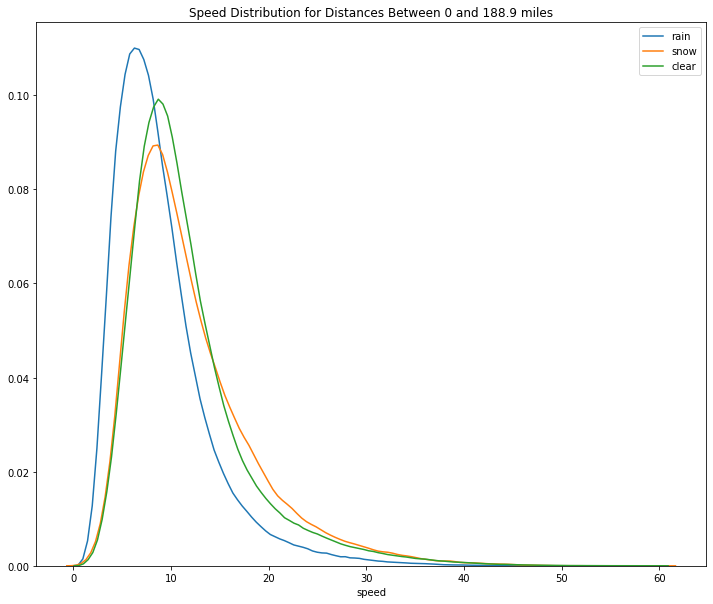

In [12]:
data_plots(0, df.trip_distance.max())

### We can see that the speed distribution for when it rains tends to be less than when it is clear / snowing

## Maybe the distributions change for different trip distances?
## Plots of speed distributions for different distance.

In [13]:
df.trip_distance.describe()

count    1.684583e+06
mean     2.853695e+00
std      3.588965e+00
min      1.000000e-01
25%      1.000000e+00
50%      1.600000e+00
75%      3.000000e+00
max      1.889000e+02
Name: trip_distance, dtype: float64

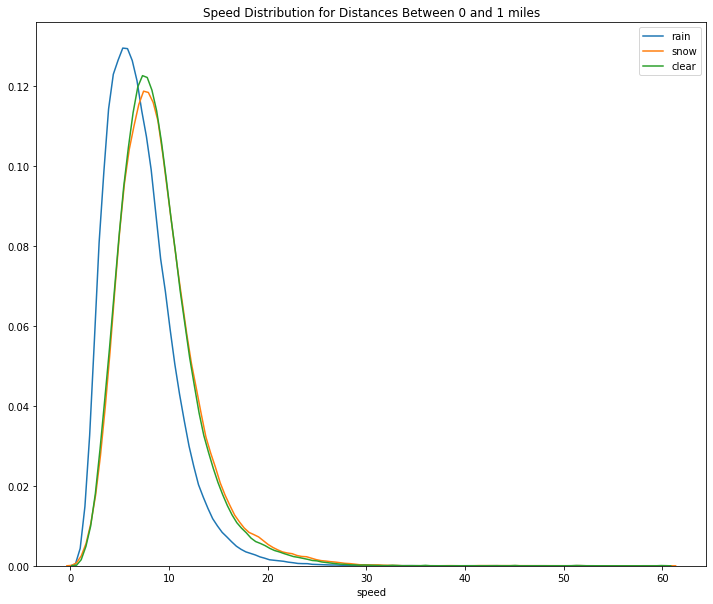

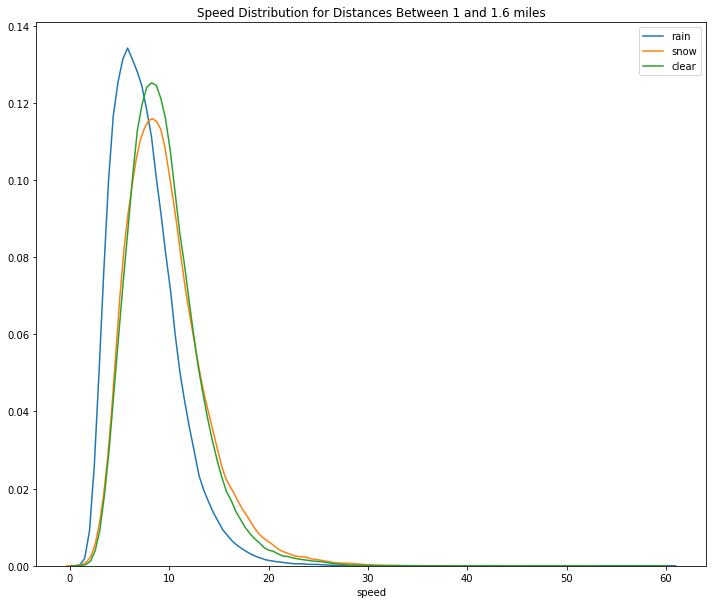

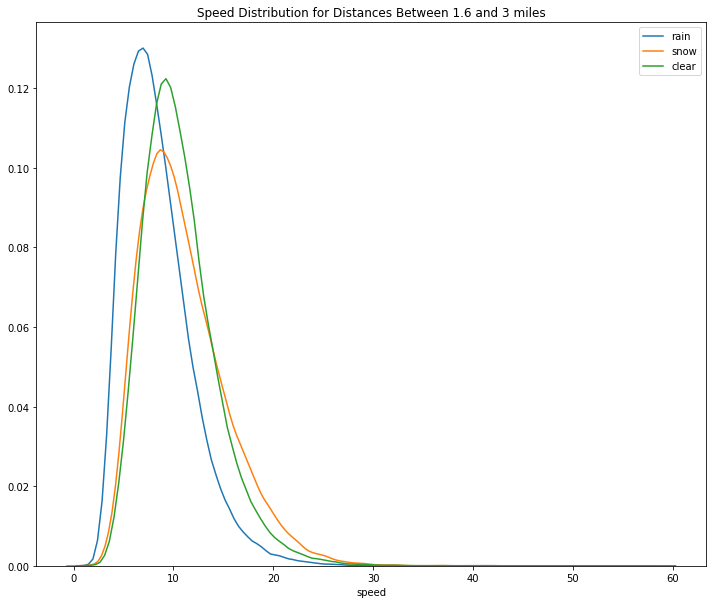

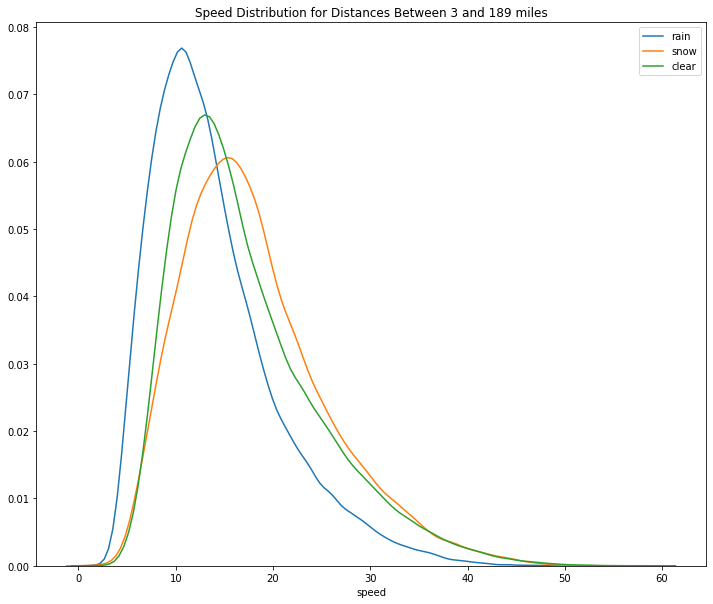

In [14]:
data_plots(0,1)
data_plots(1,1.6)
data_plots(1.6,3)
data_plots(3,189)


### We can see that for rainy days, the speed distribution is consistently lower than when it is clear / snowing

In [15]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x, y

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


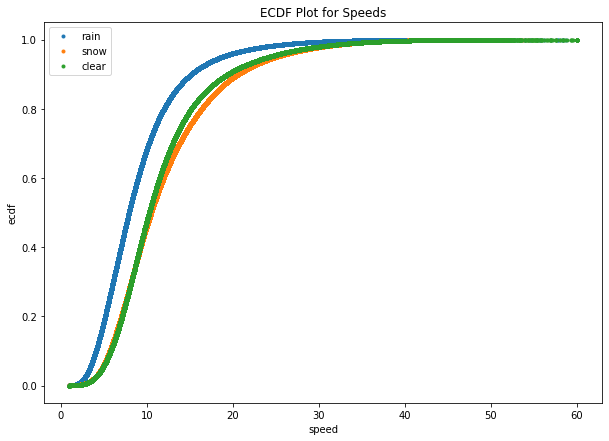

In [16]:
plt.figure(figsize = (10,7))
for i in ['rain', 'snow', 'clear']:
    x, y = ecdf(df_grouped.get_group(i).speed)
    plt.plot(x, y, marker = '.', linestyle = 'none')
plt.xlabel('speed')
plt.ylabel('ecdf')
plt.legend(['rain', 'snow', 'clear'])
plt.title('ECDF Plot for Speeds')
plt.show()

### Distribution of Trip Distances for days of rain, snow, and clear days

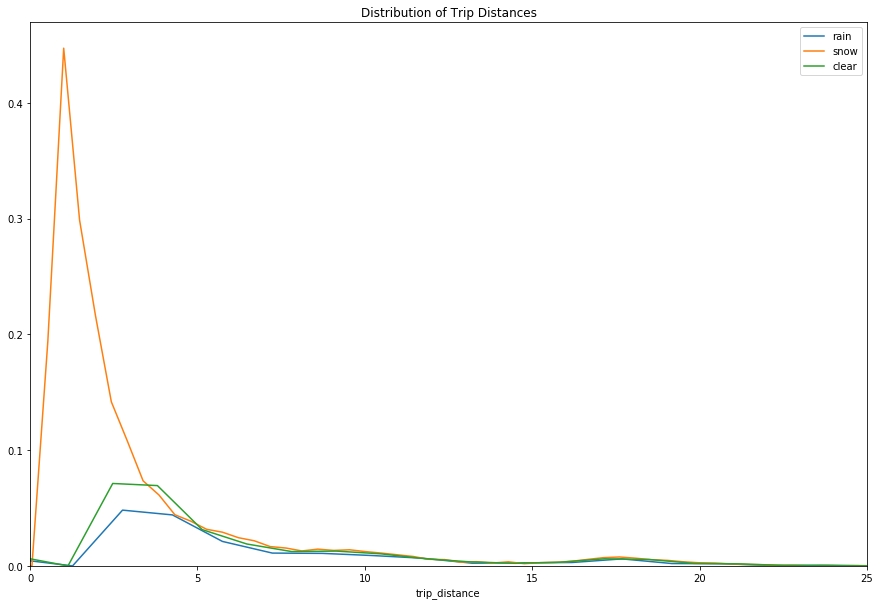

In [17]:
#plot distributions of travel distances for rain days, snow days, and clear days

plt.figure(figsize = (15,10))
plt.xlim(0,25)
plt.title('Distribution of Trip Distances')
sns.distplot(rain['trip_distance'], kde = True, hist = False, label = 'rain')
sns.distplot(snow['trip_distance'], kde = True, hist = False, label = 'snow')
sns.distplot(clear['trip_distance'], kde = True, hist = False, label = 'clear')


### Here we can see that when it snows, most of the distances will be smaller when compared to rainy or clear days.

## Let's see the number of taxi trips per hour of the day

In [18]:
days = [(11,29), (2,24), (5,3), (10,27), (3,4), (2,5), (3,21), (12,17), (7,2), (9,12)]

In [19]:
days.sort()

In [20]:
def plot_hourly(d, data):
    total_counts = []
    for i in d:
        temp_list = []
        df_grouped_day = data.groupby([data.pickup.dt.month, data.pickup.dt.day])
        date = df_grouped_day.get_group(i)
        for h in range(0,24):
            temp_list.append(len(date.groupby(date.pickup.dt.hour).get_group(h)))
        total_counts.append(temp_list)
    df_counts = pd.DataFrame(total_counts).T
    df_counts.plot(title = 'Number of Taxi Trips per Hour', figsize = (10,5))
    plt.xticks(range(1,24, 1))
    plt.xlabel('hours')
    plt.ylabel('# of trips')
    plt.grid()
    plt.legend(d)
    plt.show()

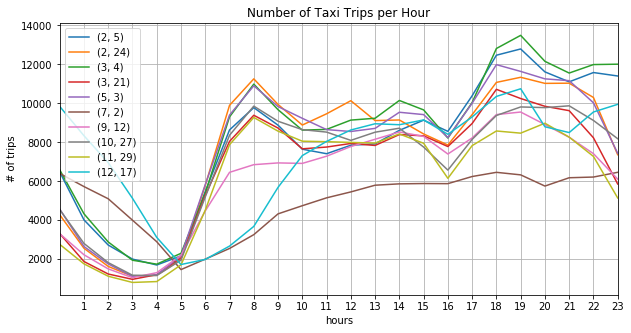

In [21]:
plot_hourly(days, df)

In [22]:
raindays = [(11,29), (2,24), (5,3), (10,27)]
raindays.sort()
snowdays = [(3,4), (2,5), (3,21), (12,17)]
snowdays.sort()
cleardays = [(7,2), (9,12)]
cleardays.sort()

## Maybe the hourly for rain days and snow days will differ from clear days.

### Rain days

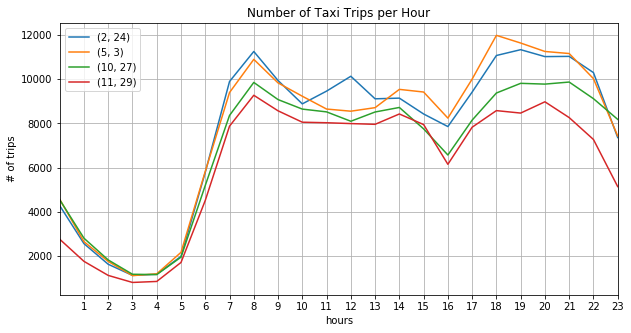

In [23]:
plot_hourly(raindays, df)

### Snow days

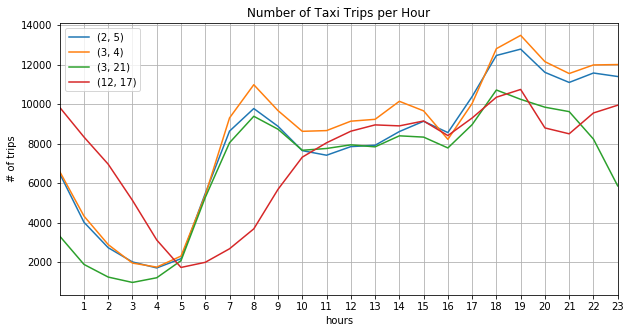

In [24]:
plot_hourly(snowdays,df)


### Clear days

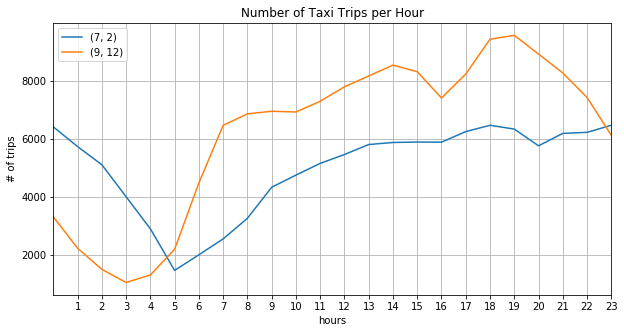

In [25]:
plot_hourly(cleardays,df)

## It does not seem like there is a clear difference in the patterns of rainy, snowy, and clear days in terms of the number of taxi trips per hour.

<function matplotlib.pyplot.show(*args, **kw)>

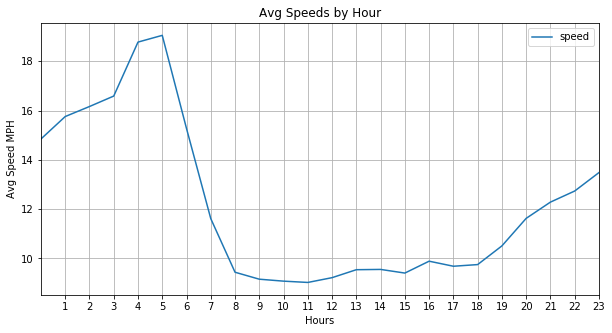

In [26]:
df.groupby(df.pickup.dt.hour).agg({'speed':'mean'}).plot(title = 'Avg Speeds by Hour', figsize = (10,5))
plt.xlabel('Hours')
plt.ylabel('Avg Speed MPH')
plt.xticks(range(1,24, 1))
plt.grid()
plt.show


## In conclusion, from this analysis we can hypothesize that higher precipitations generally slow down taxi trip speeds, as does the hour of the day.  We can also hypothesize that days in which it rains will have slower travel speeds than clear and snow days.